In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# Data

In [3]:
import os
import pickle
raw_file = './../data/dump/mimic.pickle'
with open(raw_file, 'rb') as handle:
    data = pickle.load(handle)

In [4]:
print(type(data))
print(type(data[0]))
print(data[0].keys())

<class 'list'>
<class 'dict'>
dict_keys([0, 1, 2])


In [5]:
import matplotlib.pyplot as plt

(array([1.473e+03, 7.100e+01, 2.600e+01, 5.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

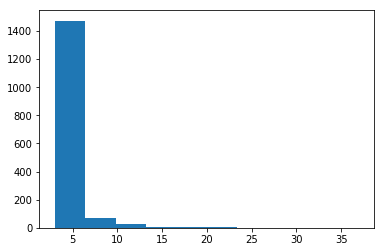

In [6]:
plt.hist(list(map(len, data)))

In [7]:
# [i for i in data[0].values()]

## Convert to dataframe

In [8]:
import pandas
import numpy as np

In [9]:
def gender_to_categorical(x):
    return 0 if x=='M' else 1

def mimic_correct_datatypes(icu_df):

    # TIMES
    icu_df['ADMITTIME'] = icu_df['ADMITTIME'].astype('datetime64')
    icu_df['DEATHTIME'] = icu_df['DEATHTIME'].astype('datetime64')
    icu_df['DISCHTIME'] = icu_df['DISCHTIME'].astype('datetime64')
    icu_df['INTIME'] = icu_df['INTIME'].astype('datetime64')
    icu_df['OUTTIME'] = icu_df['OUTTIME'].astype('datetime64')
    icu_df['DOB'] = icu_df['DOB'].astype('datetime64')

    # FLOATS
    icu_df['AGE'] = icu_df['AGE'].astype('float32')
    icu_df['LOS'] = icu_df['LOS'].astype('float32')

    # INTS
    icu_df['SUBJECT_ID'] = icu_df['SUBJECT_ID'].astype('int')
    icu_df['HADM_ID'] = icu_df['HADM_ID'].astype('int')
    icu_df['ICUSTAY_ID'] = icu_df['ICUSTAY_ID'].astype('int')
    icu_df['MORTALITY'] = icu_df['MORTALITY'].astype('int')
    return icu_df

In [10]:
def mimic_data_to_df(data, colnames=None):
    flat_data = [icu_visit for data_i in data for icu_visit in data_i.values()]
    icu_df = pandas.DataFrame(flat_data)
    icu_df = mimic_correct_datatypes(icu_df)
    icu_df['GENDER'] = icu_df['GENDER'].apply(gender_to_categorical)
    
    ethnicity_dummies = pandas.get_dummies(icu_df.ETHNICITY, drop_first=True, prefix='ETHNICITY_')
    icu_df = pandas.concat([icu_df.drop('ETHNICITY', axis=1), ethnicity_dummies], axis=1)
    
    if colnames is None:
        return icu_df
    else:
        return icu_df[colnames]

## Datatypes

In [11]:
from utils_ import get_intervals
def compute_admit_times(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            admit_times: Tensor of shape T x N x 2
    """
    max_visit_n = max([len(data_i) for data_i in data])
    admit_times = []
    for data_i in data:
        patient_admit_times = [icu_visit['ADMITTIME'] for icu_visit in data_i.values()]
        # Convert the date times str -> datetime64 -> int
        patient_admit_times = np.array(patient_admit_times).astype(np.datetime64).astype('int')
        patient_visit_n = len(patient_admit_times)
        patient_admit_times = np.pad(patient_admit_times, (0,max_visit_n-patient_visit_n), mode='constant')
        admit_times.append(patient_admit_times)
    admit_times = np.stack(admit_times).T#[:,:,np.newaxis]
    admit_times = torch.tensor(admit_times).to(device)
    intervals = get_intervals(admit_times)
    admit_times = torch.stack([admit_times, intervals], dim=-1)
    return admit_times

In [12]:
def compute_markers(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            admit_times: Tensor of shape T x N x marker_dim
    """
    max_visit_n = max([len(data_i) for data_i in data])
    markers = []
    icu_df = mimic_data_to_df(data)
    icu_df = icu_df.filter(regex='AGE|GENDER|^ETHNICITY|SUBJECT_ID', axis=1)
    group_patients = icu_df.groupby('SUBJECT_ID', )
    for patient_idx, patient_df_rows in group_patients.groups.items():
        # Get an array of shape  (T_i x marker_dim)
        patient_markers = icu_df.iloc[patient_df_rows].values
        t_i, marker_dim = patient_markers.shape
        # Get an array of shape  (T_max x marker_dim)
        patient_markers = np.pad(patient_markers, pad_width=((0,max_visit_n - t_i), (0,0)), mode='constant')
        markers.append(patient_markers)
    # Shape = T x N x marker_dim
    markers = np.stack(markers).transpose((1,0,2))
    markers = torch.tensor(markers)
    return markers

In [13]:
def mimic_data_tensors(data):
    admit_times = compute_admit_times(data)
    markers = compute_markers(data)
    data_dict = {
        't': admit_times,
        'x': markers
    }
    return data_dict

In [14]:
mimic_data = mimic_data_tensors(data)

In [18]:
mimic_data

{'t': tensor([[[5153550360, 5153550360],
          [6860550540, 6860550540],
          [5723045880, 5723045880],
          ...,
          [5062073040, 5062073040],
          [4536169080, 4536169080],
          [6175450200, 6175450200]],
 
         [[5305936500,  152386140],
          [6883313880,   22763340],
          [5746091640,   23045760],
          ...,
          [5106649020,   44575980],
          [4536580080,     411000],
          [6253518120,   78067920]],
 
         [[5414419980,  108483480],
          [6964129200,   80815320],
          [5750926740,    4835100],
          ...,
          [5108289420,    1640400],
          [4538560920,    1980840],
          [6311840940,   58322820]],
 
         ...,
 
         [[         0,          0],
          [         0,          0],
          [         0,          0],
          ...,
          [         0,          0],
          [         0,          0],
          [         0,          0]],
 
         [[         0,          0],
       

In [1]:
cd ..

/home/abhishekshar/hierarchichal_point_process


In [3]:
from utils import mimic_data_tensors

ModuleNotFoundError: No module named 'utils_'